<a href="https://colab.research.google.com/github/ClaraMikaelly-ifpi/Trabalho-Final-IA/blob/main/RedeNeural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#Aluna: Clara Mikaelly Veras da Costa

Mounted at /content/drive


In [2]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


In [3]:
grao_quebrado_orig = '/content/drive/MyDrive/trabalhoFinal/dataset/grao_quebrado'
graos_inteiros_orig = '/content/drive/MyDrive/trabalhoFinal/dataset/graos_inteiros'

base_split_dir = '/content/drive/MyDrive/trabalhoFinal/dataset_split'
train_dir_split = os.path.join(base_split_dir, 'train')
test_dir_split = os.path.join(base_split_dir, 'test')

train_grao_quebrado = os.path.join(train_dir_split, 'grao_quebrado')
test_grao_quebrado = os.path.join(test_dir_split, 'grao_quebrado')
train_graos_inteiros = os.path.join(train_dir_split, 'graos_inteiros')
test_graos_inteiros = os.path.join(test_dir_split, 'graos_inteiros')

# Crie os novos diretórios
for directory in [train_grao_quebrado, test_grao_quebrado, train_graos_inteiros, test_graos_inteiros]:
    os.makedirs(directory, exist_ok=True)

# Definir proporção de divisão
split_ratio = 0.8 # 80% para training, 20% para testing

# Função para dividir arquivos
def split_files(original_base_dir, train_target_dir, test_target_dir, ratio):
    all_files = []
    # Percorra os subdiretórios do diretório original para encontrar os arquivos
    for root, _, files in os.walk(original_base_dir):
        for f in files:
            all_files.append(os.path.join(root, f))

    random.shuffle(all_files)
    train_count = int(len(all_files) * ratio)
    train_files = all_files[:train_count]
    test_files = all_files[train_count:]

    print(f"Splitting from {original_base_dir}: {len(train_files)} for training, {len(test_files)} for testing.")

    for src_path in train_files:
        # Obtenha o nome do arquivo relativo ao diretório base original
        relative_path = os.path.relpath(src_path, original_base_dir)
        dest_path = os.path.join(train_target_dir, relative_path)
        # Crie o diretório de destino se ele não existir
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copy(src_path, dest_path)


    for src_path in test_files:
       # Obtenha o nome do arquivo relativo ao diretório base original
        relative_path = os.path.relpath(src_path, original_base_dir)
        dest_path = os.path.join(test_target_dir, relative_path)
        # Crie o diretório de destino se ele não existir
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copy(src_path, dest_path)


split_files(grao_quebrado_orig, train_grao_quebrado, test_grao_quebrado, split_ratio)
split_files(graos_inteiros_orig, train_graos_inteiros, test_graos_inteiros, split_ratio)

print("Contents of original grao_quebrado directory:")
# Listar apenas arquivos nos diretórios originais
print([f for f in os.listdir(grao_quebrado_orig) if os.path.isfile(os.path.join(grao_quebrado_orig, f))])

print("\nContents of original graos_inteiros directory:")
print([f for f in os.listdir(graos_inteiros_orig) if os.path.isfile(os.path.join(graos_inteiros_orig, f))])

print("Dataset split complete.")

Splitting from /content/drive/MyDrive/trabalhoFinal/dataset/grao_quebrado: 59 for training, 15 for testing.
Splitting from /content/drive/MyDrive/trabalhoFinal/dataset/graos_inteiros: 94 for training, 24 for testing.
Contents of original grao_quebrado directory:
[]

Contents of original graos_inteiros directory:
[]
Dataset split complete.


In [4]:
train_dir = '/content/drive/MyDrive/trabalhoFinal/dataset_split/train'
test_dir = '/content/drive/MyDrive/trabalhoFinal/dataset_split/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size = (64, 64),
  batch_size = 16,
  class_mode='binary',
  shuffle = True
)

test_generator = test_datagen.flow_from_directory(
  test_dir,
  target_size = (64, 64),
  batch_size = 16,
  class_mode='binary',
  shuffle = False
)

from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0, 1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_generator.classes)
class_weights = dict(zip(classes, weights))
print("Class weights: ",class_weights)

Found 339 images belonging to 2 classes.
Found 111 images belonging to 2 classes.
Class weights:  {np.int64(0): np.float64(1.3038461538461539), np.int64(1): np.float64(0.8110047846889952)}


In [18]:
model = Sequential([
    Input(shape=(64, 64, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilação
model.compile(
    optimizer = Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)


# Treinamento
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stop],
    class_weight=class_weights
)

# 1. Avalia o modelo treinado usando o test_generator e imprime a precisão do teste.
loss, acc = model.evaluate(test_generator)
print(f"Acurácia no conjunto de teste: {acc:.4f}")


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.5654 - loss: 1.0315 - val_accuracy: 0.3784 - val_loss: 0.6881
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.5381 - loss: 0.8322 - val_accuracy: 0.7387 - val_loss: 0.6859
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.6691 - loss: 0.5722 - val_accuracy: 0.6306 - val_loss: 0.6579
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 294ms/step - accuracy: 0.8142 - loss: 0.4643 - val_accuracy: 0.8829 - val_loss: 0.6446
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.8397 - loss: 0.3620 - val_accuracy: 0.9369 - val_loss: 0.6012
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.7975 - loss: 0.5096 - val_accuracy: 0.6216 - val_loss: 0.6156
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.8338 - loss: 0.4060 - val_accuracy: 0.7838 - val_loss: 0.5887
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.8659 - loss: 0.3079 - val_accuracy: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step

Relatório de Classificação:
                precision    recall  f1-score   support

 grao_quebrado       0.98      0.98      0.98        42
graos_inteiros       0.99      0.99      0.99        69

      accuracy                           0.98       111
     macro avg       0.98      0.98      0.98       111
  weighted avg       0.98      0.98      0.98       111



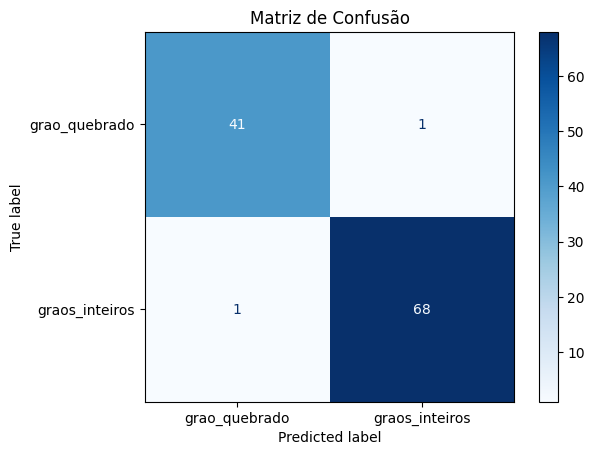

In [19]:
# 2. Generate predictions on the test data using the trained model.
pred_probs = model.predict(test_generator, verbose=1)

# 3. Get the true labels from the test_generator.
# 4. Generate and print a classification report using the true labels and predicted labels.
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_true = test_generator.classes
y_pred = (pred_probs > 0.5).astype(int).reshape(-1)

print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# 5. Generate and display a confusion matrix using the true labels and predicted labels, with appropriate labels for the axes and title.
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

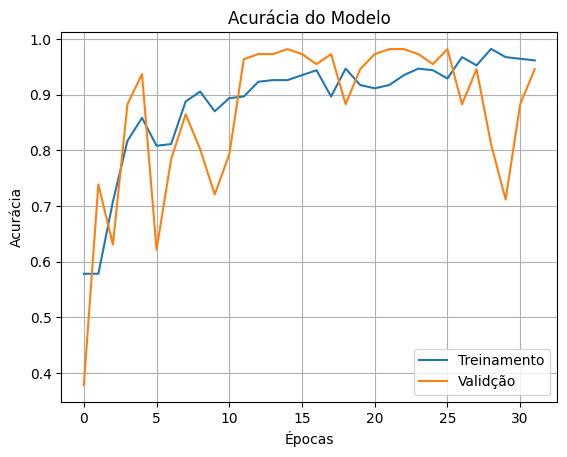

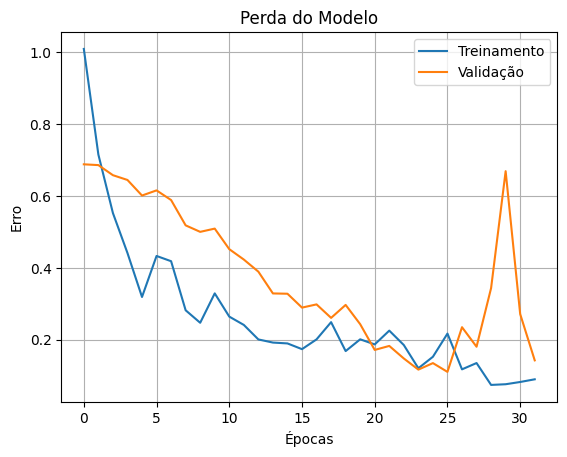

In [20]:
# 6. Plot the training and validation accuracy over epochs using the history object.
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validção')
plt.title('Acurácia do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

# 7. Plot the training and validation loss over epochs using the history object.
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.legend()
plt.grid(True)
plt.show()